## <font color=red>$$ #Melanoma Detection Assignment$$</font>
<font color=blue>**Contributors:**</font><br>
<font color=red>Aakash Sharma</font>



> ### <font color=red>Importing all Important Libraries</font>


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

> ### <font color=red>Data Reading & Understanding</font>

> This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [10]:
# If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
# Importing Skin Cancer Data
# Defining the path for train and test images

root_path = '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [26]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [27]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

> Use 80% of the images for training, and 20% for validation.

In [28]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [29]:

# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [30]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [31]:
# Listing out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


> ### <font color=red>Data Visualisation</font>

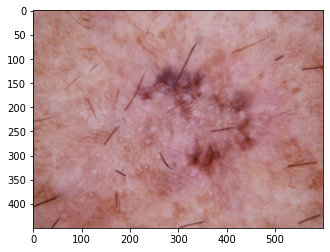

In [32]:
import matplotlib.pyplot as plt

image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)



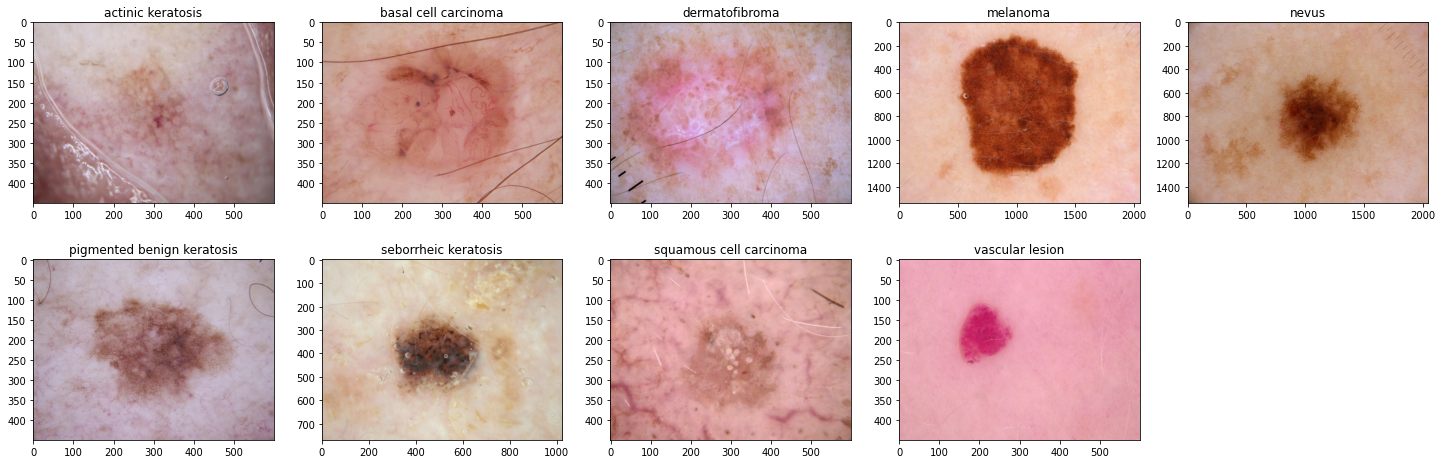

In [33]:
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

> The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

> `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

> `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [34]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

> ### <font color=red>Model Building & Training</font>

In [39]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [40]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 259200)            0

In [41]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 245s 934ms/step - loss: 3.0994 - accuracy: 0.2344 - val_loss: 1.8385 - val_accuracy: 0.3691
Epoch 2/20
56/56 [==============================] - 4s 77ms/step - loss: 1.6606 - accuracy: 0.4068 - val_loss: 1.5424 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 4s 76ms/step - loss: 1.4621 - accuracy: 0.4978 - val_loss: 1.4421 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - 4s 79ms/step - loss: 1.4631 - accuracy: 0.4777 - val_loss: 1.4570 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 5s 82ms/step - loss: 1.3041 - accuracy: 0.5234 - val_loss: 1.7037 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 4s 76ms/step - loss: 1.2486 - accuracy: 0.5603 - val_loss: 1.5349 - val_accuracy: 0.4743
Epoch 7/20
56/56 [==============================] - 4s 76ms/step - loss: 1.0618 - accuracy: 0.6250 - val_loss: 1.4439 - val_accuracy: 0.5347
Epoch 8/20

In [42]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

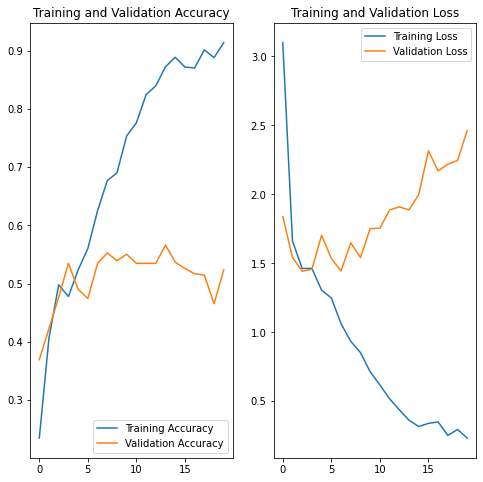

In [43]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

**Findings :**

> 1. As the training accuracy increases linearly over time, where as the validation accuracy stall at 50% accuracy in training process. 
2. As the training loss dereases with epochs the validation loss increases.
3. The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved around **50% accuracy** on the validation set.
4. The difference in accuracy between training and validation accuracy is **noticeable** which is a sign of overfitting.




> ### <font color=red>Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting</font>


> Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [44]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

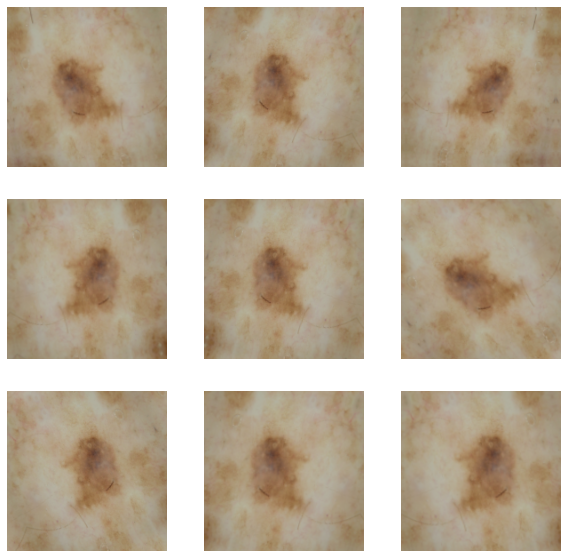

In [45]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

> ### <font color=red>Model Building & training on the augmented data</font>

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [46]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [47]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [48]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 102ms/step - loss: 3.0223 - accuracy: 0.2126 - val_loss: 2.0676 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 7s 122ms/step - loss: 1.8685 - accuracy: 0.3237 - val_loss: 1.6554 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 5s 93ms/step - loss: 1.6620 - accuracy: 0.4051 - val_loss: 1.5497 - val_accuracy: 0.4273
Epoch 4/20
56/56 [==============================] - 5s 93ms/step - loss: 1.5741 - accuracy: 0.4442 - val_loss: 1.5164 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 6s 114ms/step - loss: 1.5199 - accuracy: 0.4503 - val_loss: 1.5726 - val_accuracy: 0.4116
Epoch 6/20
56/56 [==============================] - 5s 95ms/step - loss: 1.4595 - accuracy: 0.4743 - val_loss: 1.5249 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 5s 94ms/step - loss: 1.4308 - accuracy: 0.4849 - val_loss: 1.5089 - val_accuracy: 0.4631
Epoch 8/20

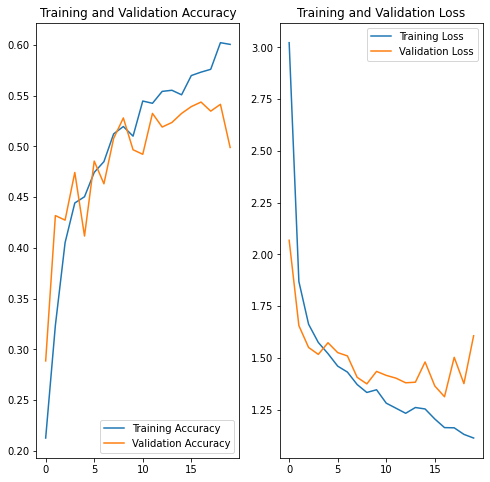

In [49]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

**Findings :**

> 1. As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
2. As the training loss decreases with epochs the validation loss decreases and stalls.
3. The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around **55% accuracy** on the validation set.
4. The difference in accuracy between training and validation accuracy is still **slightly noticeable** which is a sign of overfitting.

> ### <font color=red>Model Building & training on the augmented data with dropout</font>

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [50]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [51]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [52]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 98ms/step - loss: 3.2250 - accuracy: 0.2561 - val_loss: 1.6970 - val_accuracy: 0.4295
Epoch 2/20
56/56 [==============================] - 5s 96ms/step - loss: 1.6231 - accuracy: 0.4252 - val_loss: 1.4773 - val_accuracy: 0.5056
Epoch 3/20
56/56 [==============================] - 5s 95ms/step - loss: 1.4749 - accuracy: 0.4860 - val_loss: 1.4932 - val_accuracy: 0.4944
Epoch 4/20
56/56 [==============================] - 5s 95ms/step - loss: 1.4540 - accuracy: 0.4821 - val_loss: 1.5826 - val_accuracy: 0.4474
Epoch 5/20
56/56 [==============================] - 5s 96ms/step - loss: 1.4151 - accuracy: 0.5006 - val_loss: 1.4124 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 5s 96ms/step - loss: 1.3281 - accuracy: 0.5312 - val_loss: 1.3747 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 5s 96ms/step - loss: 1.3197 - accuracy: 0.5329 - val_loss: 1.4529 - val_accuracy: 0.5034
Epoch 8/20
56

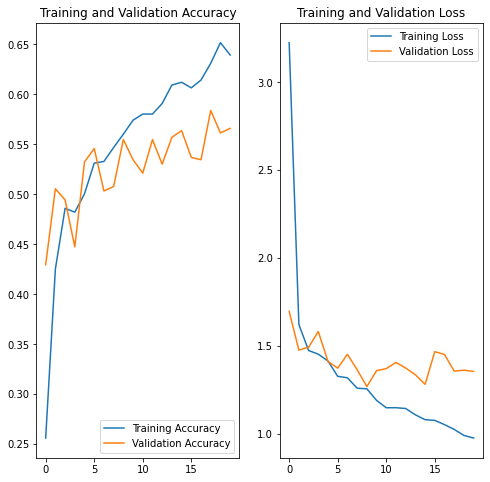

In [53]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

**Findings :**

>1. As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
2. **As the training loss decreases with epochs the validation loss decreases**
3. The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
4. The difference in accuracy between training and validation accuracy is **very less**

### **We can clearly see that the overfitting of the model has redused significantly when compared the earlier models**

> ### <font color=red>Class distribution</font>

Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [54]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


**Findings :**

> Which class has the least number of samples?
    
    seborrheic keratosis with 77 samples

> Which classes dominate the data in terms proportionate number of samples?
    
    pigmented benign keratosis with 462 samples

> ### <font color=red>Handling class imbalances</font>

Rectifing class imbalances present in the training dataset with Augmentor library.

In [81]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [92]:
#import shutil
#shutil.rmtree("/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/")

In [93]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory="/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/output_augmentor/"+i+"/")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/output_augmentor/actinic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB85ABD8850>: 100%|██████████| 500/500 [00:19<00:00, 26.23 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/output_augmentor/basal cell carcinoma/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB85AB98460>: 100%|██████████| 500/500 [00:18<00:00, 26.75 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/output_augmentor/dermatofibroma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB85C75C550>: 100%|██████████| 500/500 [00:19<00:00, 25.43 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/output_augmentor/melanoma/.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FB85C2F56A0>: 100%|██████████| 500/500 [01:33<00:00,  5.37 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/output_augmentor/nevus/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB87207F400>: 100%|██████████| 500/500 [01:27<00:00,  5.69 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/output_augmentor/pigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB85ACC9AF0>: 100%|██████████| 500/500 [00:19<00:00, 26.23 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/output_augmentor/seborrheic keratosis/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FB8724A7A30>: 100%|██████████| 500/500 [00:43<00:00, 11.50 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/output_augmentor/squamous cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB85C2F56A0>: 100%|██████████| 500/500 [00:19<00:00, 25.84 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/output_augmentor/vascular lesion/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB85ACC92B0>: 100%|██████████| 500/500 [00:19<00:00, 26.05 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [94]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/output_augmentor/")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

4500


> Lets see the distribution of augmented data after adding new images to the original training data.

In [95]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [96]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [97]:
df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [98]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [99]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [100]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


> ### <font color=red>Model Building & training on the rectified class imbalance data </font>

> * Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, we include normalization.
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~30 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [101]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [102]:
# Compiling the model - Choose optimizer and loss function appropriately
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [103]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
113/113 [==============================] - 22s 176ms/step - loss: 2.4241 - accuracy: 0.3028 - val_loss: 1.8100 - val_accuracy: 0.3278
Epoch 2/30
113/113 [==============================] - 20s 173ms/step - loss: 1.5909 - accuracy: 0.4053 - val_loss: 1.4058 - val_accuracy: 0.4300
Epoch 3/30
113/113 [==============================] - 20s 169ms/step - loss: 1.4022 - accuracy: 0.4706 - val_loss: 1.5420 - val_accuracy: 0.4156
Epoch 4/30
113/113 [==============================] - 20s 169ms/step - loss: 1.3426 - accuracy: 0.4831 - val_loss: 1.4249 - val_accuracy: 0.4589
Epoch 5/30
113/113 [==============================] - 20s 172ms/step - loss: 1.2832 - accuracy: 0.5094 - val_loss: 1.3035 - val_accuracy: 0.4889
Epoch 6/30
113/113 [==============================] - 20s 168ms/step - loss: 1.2719 - accuracy: 0.5278 - val_loss: 1.2883 - val_accuracy: 0.4933
Epoch 7/30
113/113 [==============================] - 20s 168ms/step - loss: 1.1943 - accuracy: 0.5422 - val_loss: 1.1541 - val_ac

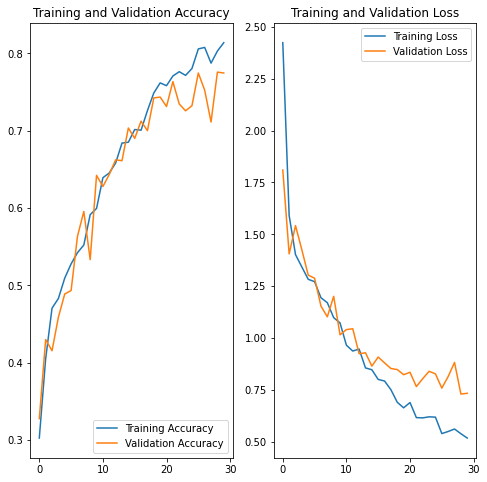

In [104]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

**Findings :**

> 1. As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.
2. As the training loss decreases with epochs the validation loss also decreases.
3. The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around **75% accuracy** on the validation set.
4. The difference in accuracy between training and validation accuracy is **very less**.

## <font color=green>**Class rebalancing not only got rid of overfitting it also improved the accuracy from 55% to 75%.**</font>


## <font color=red>$$ # END $$</font>